# 【自前AI講座】畳み込みニューラルネットワークの基礎

---

## 畳み込み層

$$
A \circledast B = \sum_{i,j}{a_{ij} b_{ij}}
$$

$$
y_{11} = w_{11} x_{11} + w_{12} x_{12} + w_{21} x_{21} + w_{22} x_{22} + b \\
y_{12} = w_{12} x_{12} + w_{13} x_{13} + w_{22} x_{22} + w_{23} x_{23} + b \\
y_{21} = w_{21} x_{21} + w_{22} x_{22} + w_{31} x_{31} + w_{32} x_{32} + b
$$

## プーリング層

$$
y_{11} = \max{(x_{11}, \ x_{12}, \ x_{21}, \ x_{22})} \\
y_{12} = \max{(x_{12}, \ x_{13}, \ x_{22}, \ x_{23})}
$$

$$
y_{11} = \frac{1}{4} \ (x_{11} + x_{12} + x_{21} + x_{22}) \\
y_{12} = \frac{1}{4} \ (x_{12} + x_{13} + x_{22} + x_{23})
$$

## Global Average Pooling 層

$$
y_{ij} = \frac{1}{n} \sum_{k=1}^{n}{x_{11}^{(k)}}
$$

## 実践：畳み込みニューラルネットワーク

In [ ]:
!nvidia-smi

Tue Feb 14 18:38:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import gc
import os
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from keras import layers, Model, optimizers, losses, metrics, callbacks
sns.set()

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(x_train.dtype, y_train.dtype, x_test.dtype, y_test.dtype)

170498071/170498071 [==============================] - 5s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
uint8 uint8 uint8 uint8


In [4]:
label_name = {
    "0": "airplane",
    "1": "automobile",
    "2": "bird",
    "3": "cat",
    "4": "deer",
    "5": "dog",
    "6": "frog",
    "7": "horse",
    "8": "ship",
    "9": "truck",
}

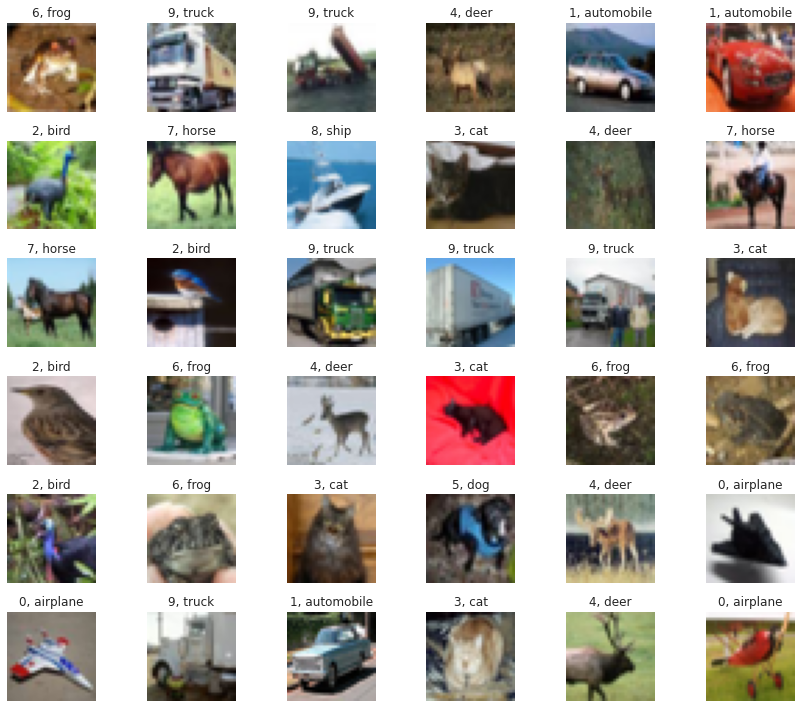

In [5]:
num = 36
fig = plt.figure(figsize=(12, 10))
ax = [None] * num
for i in range(num):
    ax[i] = fig.add_subplot(6, 6, i + 1)
    ax[i].imshow(x_train[i])
    ax[i].set_title(f"{y_train[i][0]}, {label_name[str(y_train[i][0])]}")
    ax[i].grid(None)
    ax[i].axis("off")
fig.tight_layout()
plt.show()

In [6]:
# 画素値を 0～255 から 0～1 に正規化
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

In [7]:
# クラス数を算出
classes = len(label_name)
classes

10

In [8]:
tf.keras.backend.clear_session()
gc.collect()

inputs = layers.Input(shape=x_train.shape[1:])
x = inputs
x = layers.Flatten()(x)
x = layers.Dense(units=64, kernel_initializer="he_normal")(x)
x = layers.ReLU()(x)
x = layers.Dense(units=classes, kernel_initializer="glorot_uniform")(x)
x = layers.Softmax()(x)
outputs = x
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model.summary()

t_start = time.perf_counter()

model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test, y_test),
    batch_size=64,
    epochs=10,
)

print(f"\nelapsed: {time.perf_counter() - t_start:.3f} [s]")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 64)                196672    
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
 softmax (Softmax)           (None, 10)                0         
                                                                 
Total params: 197,322
Trainable params: 197,322
Non-trainable

In [9]:
def plot_history(model):
    history = model.history
    epoch = np.array(history.epoch) + 1

    scores = history.history
    acc_train = scores["sparse_categorical_accuracy"]
    acc_val = scores["val_sparse_categorical_accuracy"]
    loss_train = scores["loss"]
    loss_val = scores["val_loss"]

    fig = plt.figure(figsize=(10, 4), facecolor="white")
    ax0 = fig.add_subplot(1, 2, 1)
    ax1 = fig.add_subplot(1, 2, 2)
    ax0.plot(epoch, acc_train, label="train")
    ax0.plot(epoch, acc_val, label="validation")
    ax0.set_xlabel("epoch")
    ax0.set_ylabel("accuracy")
    ax0.set_ylim(-0.05, 1.05)
    ax0.legend(loc="best")

    ax1.plot(epoch, loss_train, label="train")
    ax1.plot(epoch, loss_val, label="validation")
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("loss")
    ax1.legend(loc="best")

    fig.tight_layout()
    plt.show()

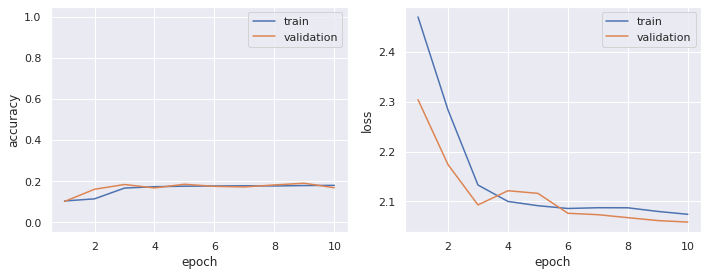

In [10]:
plot_history(model=model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                             

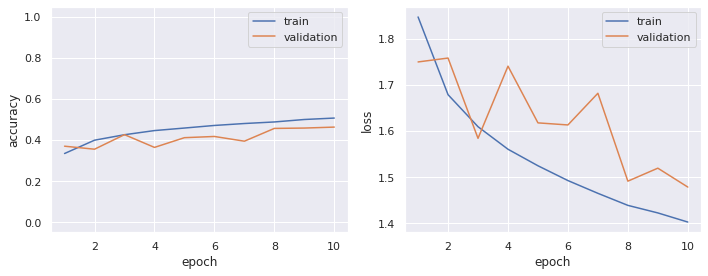

In [11]:
tf.keras.backend.clear_session()
gc.collect()

inputs = layers.Input(shape=x_train.shape[1:])
x = inputs
x = layers.Flatten()(x)
for i in range(4):
    x = layers.Dense(units=128, kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(rate=0.2)(x)
x = layers.Dense(units=classes, kernel_initializer="glorot_uniform")(x)
x = layers.Softmax()(x)
outputs = x
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model.summary()

t_start = time.perf_counter()

model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test, y_test),
    batch_size=64,
    epochs=10,
)
print(f"\nelapsed: {time.perf_counter() - t_start:.3f} [s]")
plot_history(model=model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 31, 31, 64)        832       
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 64)       256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 31, 31, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        16448 

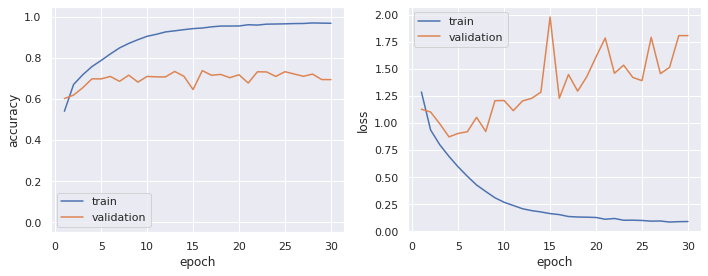

In [12]:
tf.keras.backend.clear_session()
gc.collect()

inputs = layers.Input(shape=x_train.shape[1:])
x = inputs
for i in range(2):
    x = layers.Conv2D(
        filters=64,
        kernel_size=(2, 2),
        strides=(1, 1),
        padding="valid",
        kernel_initializer="he_normal",
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding="valid")(x)
x = layers.Conv2D(
    filters=64, kernel_size=(2, 2), strides=(1, 1), padding="valid", kernel_initializer="he_normal",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Flatten()(x)
x = layers.Dense(units=128, kernel_initializer="he_normal")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(rate=0.3)(x)
x = layers.Dense(units=classes, kernel_initializer="glorot_uniform")(x)
x = layers.Softmax()(x)
outputs = x
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model.summary()

t_start = time.perf_counter()

model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test, y_test),
    batch_size=64,
    epochs=30,
)
print(f"\nelapsed: {time.perf_counter() - t_start:.3f} [s]")
plot_history(model=model)

In [13]:
warm_up_epoch = 3
max_lr = 0.01
final_epoch = 30


def lr_scheduler(epoch: int, _: float) -> float:
    if epoch <= warm_up_epoch:
        scheduled_lr = epoch / warm_up_epoch * max_lr
    else:
        scheduled_lr = (
            (
                math.cos(
                    (epoch - warm_up_epoch) / (final_epoch - warm_up_epoch) * math.pi
                )
                + 1
            )
            * max_lr
            / 2
        )
    scheduled_lr = round(scheduled_lr, ndigits=9)
    return scheduled_lr

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 31, 31, 64)        832       
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 64)       256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 31, 31, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        16448 

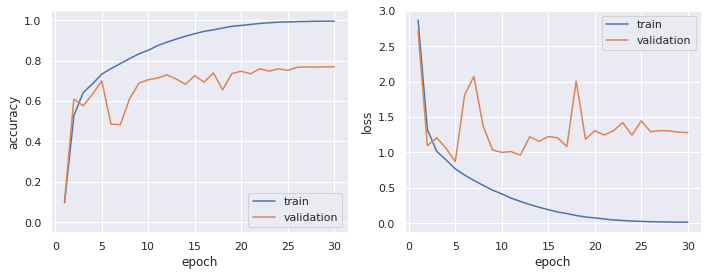

In [14]:
tf.keras.backend.clear_session()
gc.collect()

inputs = layers.Input(shape=x_train.shape[1:])
x = inputs
for i in range(2):
    x = layers.Conv2D(
        filters=64,
        kernel_size=(2, 2),
        strides=(1, 1),
        padding="valid",
        kernel_initializer="he_normal",
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding="valid")(x)
x = layers.Conv2D(
    filters=64, kernel_size=(2, 2), strides=(1, 1), padding="valid", kernel_initializer="he_normal",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Flatten()(x)
x = layers.Dense(units=128, kernel_initializer="he_normal")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(rate=0.3)(x)
x = layers.Dense(units=classes, kernel_initializer="glorot_uniform")(x)
x = layers.Softmax()(x)
outputs = x
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model.summary()

t_start = time.perf_counter()

model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test, y_test),
    batch_size=64,
    epochs=final_epoch,
    callbacks=[
        callbacks.LearningRateScheduler(
            schedule=lr_scheduler,
            verbose=0,
        ),
    ],)

print(f"\nelapsed: {time.perf_counter() - t_start:.3f} [s]")
plot_history(model=model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 31, 31, 64)        832       
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 64)       256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 31, 31, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        16448 

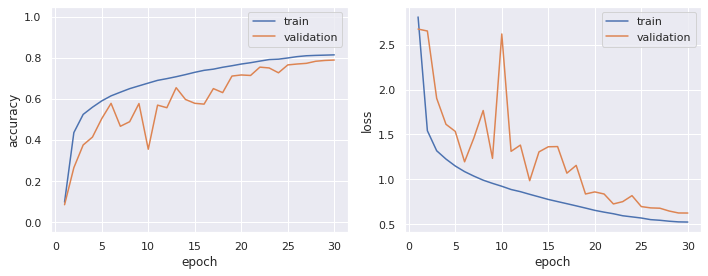

In [15]:
tf.keras.backend.clear_session()
gc.collect()

inputs = layers.Input(shape=x_train.shape[1:])
x = inputs
for i in range(2):
    x = layers.Conv2D(
        filters=64,
        kernel_size=(2, 2),
        strides=(1, 1),
        padding="valid",
        kernel_initializer="he_normal",
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding="valid")(x)
x = layers.Conv2D(
    filters=64,
    kernel_size=(2, 2),
    strides=(1, 1),
    padding="valid",
    kernel_initializer="he_normal",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(units=128, kernel_initializer="he_normal")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(rate=0.3)(x)
x = layers.Dense(units=classes, kernel_initializer="glorot_uniform")(x)
x = layers.Softmax()(x)
outputs = x
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model.summary()

t_start = time.perf_counter()

model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test, y_test),
    batch_size=64,
    epochs=final_epoch,
    callbacks=[
        callbacks.LearningRateScheduler(
            schedule=lr_scheduler,
            verbose=0,
        ),
    ],)

print(f"\nelapsed: {time.perf_counter() - t_start:.3f} [s]")
plot_history(model=model)